In [40]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/facebookresearch/segment-anything.git

  Cloning https://github.com/huggingface/transformers.git to /private/var/folders/ts/fyk14wcs1f33wl_y1jg8jdk00000gn/T/pip-req-build-golvkcxp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /private/var/folders/ts/fyk14wcs1f33wl_y1jg8jdk00000gn/T/pip-req-build-golvkcxp
  Resolved https://github.com/huggingface/transformers.git to commit 3a8eb74668e9c2cc563b2f5c62fac174797063e0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
ERROR: Package 'transformers' requires a different Python: 3.8.20 not in '>=3.9.0'
  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/ts/fyk14wcs1f33wl_y1jg8jdk00000gn/T/pip-req-build-y2zmc8tt
  Running command git clone --filter=blob:none --

In [41]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("dataclusterlabs/vehicle-image-captioning-dataset")

print("Path to dataset files:", path)

100%|██████████| 166M/166M [00:18<00:00, 9.33MB/s] 

Extracting model files...


Path to dataset files: /Users/yaowenyi/.cache/kagglehub/datasets/dataclusterlabs/vehicle-image-captioning-dataset/versions/1


In [42]:
!mv "/Users/yaowenyi/.cache/kagglehub/datasets/dataclusterlabs/vehicle-image-captioning-dataset" .

mv: rename /Users/yaowenyi/.cache/kagglehub/datasets/dataclusterlabs/vehicle-image-captioning-dataset to ./vehicle-image-captioning-dataset: Directory not empty


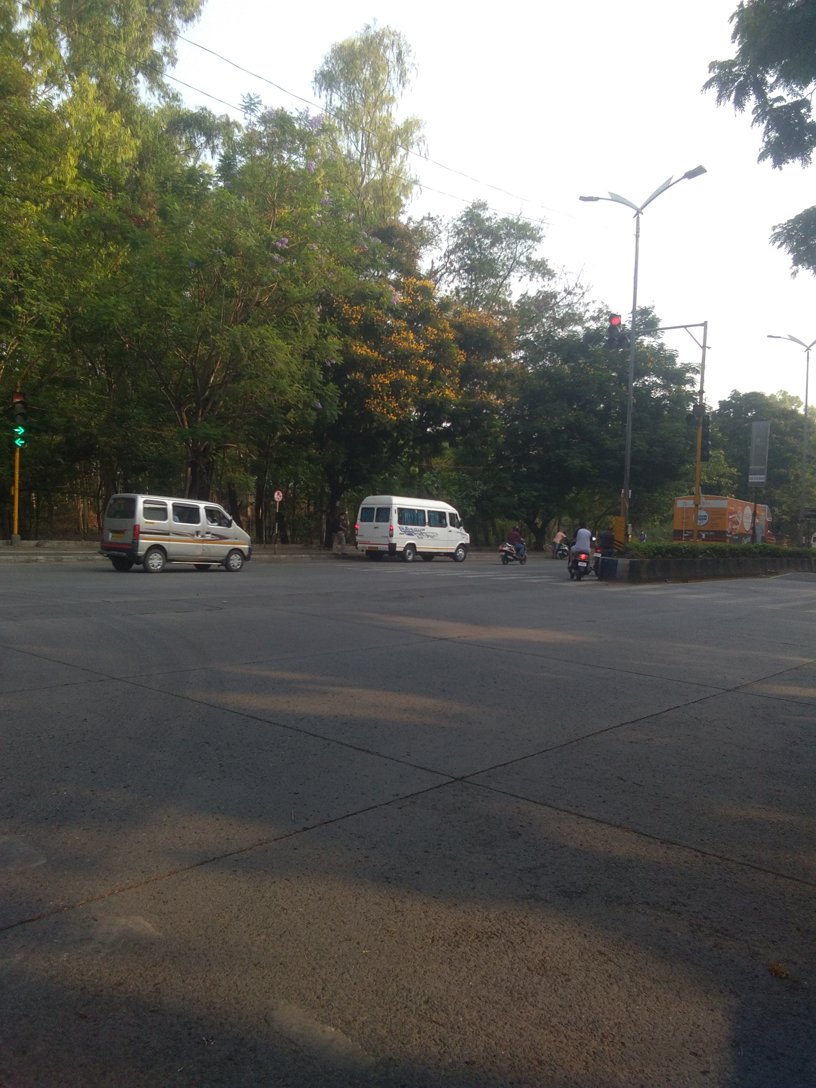

In [ ]:
import requests
from PIL import Image

path = 'vehicle-image-captioning-dataset/versions/1/indian_vehicle_images/indian_vehicle_images/dc_vehicle_captions_000001_13WxIVNH.jpg'
image = Image.open(path).convert('RGB')

width, height = image.size
display(image.resize((width // 3, height // 3)))

In [44]:
import wget

url = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
output_path = wget.download(url)
print(f"Downloaded file saved to: {output_path}")


Downloaded file saved to: sam_vit_h_4b8939 (1).pth


In [45]:
import torch
import numpy as np
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator

# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = 'sam_vit_h_4b8939.pth'

# SAM initialization
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model)
predictor.set_image(np.array(image)) # load the image to predictor

model

/Users/yaowenyi/Downloads/Fall 2024/AvancedAI/group project/.venv/lib/python3.8/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

In [46]:
image = np.array(image)
masks = mask_generator.generate(image)

In [ ]:
# Load SAM model
sam_checkpoint = "sam_vit_h_4b8939.pth"
sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
mask_generator = SamAutomaticMaskGenerator(sam)

# Load image
path = 'vehicle-image-captioning-dataset/versions/1/indian_vehicle_images/indian_vehicle_images/dc_vehicle_captions_000001_13WxIVNH.jpg'
image = Image.open(path).convert('RGB')
image = np.array(image)

# Generate masks
masks = mask_generator.generate(image)

for i, mask in enumerate(masks):
    print(f"Mask {i} keys: {mask.keys()}")

    # Get stability_score
    stability_score = mask.get("stability_score", "N/A")
    bbox = mask.get("bbox", [0, 0, 0, 0])
    area = mask.get("area", "N/A")

    print(f"Object {i}: Bounding Box = {bbox}, Area = {area}, Stability Score = {stability_score}")

    # Crop
    segmentation = mask["segmentation"].astype("uint8")
    cropped_mask = cv2.bitwise_and(image, image, mask=segmentation)
    x, y, w, h = bbox
    cropped_object = cropped_mask[y:y+h, x:x+w]

    # PIL
    cropped_pil = Image.fromarray(cropped_object)
    cropped_pil.show()


Mask 0 keys: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Object 0: Bounding Box = [499, 0, 1948, 1576], Area = 1065698, Stability Score = 0.953280508518219
Mask 1 keys: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Object 1: Bounding Box = [6, 1661, 2439, 1602], Area = 3782943, Stability Score = 0.9936092495918274
Mask 2 keys: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Object 2: Bounding Box = [0, 56, 2447, 3207], Area = 3810890, Stability Score = 0.9516845941543579
Mask 3 keys: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
Object 3: Bounding Box = [2109, 0, 338, 826], Area = 132643, Stability Score = 0.9843659996986389
Mask 4 keys: dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box']

GIT-base

In [95]:
from transformers import AutoProcessor, AutoModelForCausalLM
git_processor = AutoProcessor.from_pretrained("microsoft/git-base")
git_captioning_model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")
device = "cuda" if torch.cuda.is_available() else "cpu"
git_captioning_model = git_captioning_model.to(device)

Zero-shot Image Captioning with GIT

In [ ]:
path = 'vehicle-image-captioning-dataset/versions/1/indian_vehicle_images/indian_vehicle_images/dc_vehicle_captions_000001_13WxIVNH.jpg'
image = Image.open(path).convert('RGB')
image = np.array(image)

# Prepare the inputs for the model
inputs = git_processor(images=image, return_tensors="pt").to(device)

# Generate the caption
outputs = git_captioning_model.generate(**inputs, max_new_tokens=50)
caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Zero-Shot Caption with GIT:", caption)

Zero-Shot Caption with GIT: the trees are green


In [ ]:
from jiwer import wer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from pycocoevalcap.cider.cider import Cider
import pandas as pd

# File paths
image_dir = "vehicle-image-captioning-dataset/versions/1/indian_vehicle_images/indian_vehicle_images"
anno_dir = "vehicle-image-captioning-dataset/versions/1/indian_vehicle_txt_annos/indian_vehicle_txt_annos"

# Traverse folders
image_files = sorted(os.listdir(image_dir))
anno_files = sorted(os.listdir(anno_dir))

# Initialize result storage
results = []
cider_scorer = Cider()

for img_file, anno_file in zip(image_files, anno_files):
    # Load image
    image_path = os.path.join(image_dir, img_file)
    image = Image.open(image_path).convert('RGB')
    image = np.array(image)
    
    # Load annotation (Ground Truth)
    anno_path = os.path.join(anno_dir, anno_file)
    with open(anno_path, 'r') as f:
        ground_truth = f.read().strip()
    
    # Generate zero-shot caption
    inputs = git_processor(images=image, return_tensors="pt").to(device)
    outputs = git_captioning_model.generate(**inputs, max_new_tokens=200)
    generated_caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Compute WER
    wer_score = wer(ground_truth, generated_caption)
    
    # Compute BLEU
    reference = [ground_truth.split()]
    candidate = generated_caption.split()
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    
    # Prepare for CIDEr
    gts = {0: [ground_truth]}  
    res = {0: [generated_caption]}  

    # Compute CIDEr score
    cider_score, _ = cider_scorer.compute_score(gts, res)
    
    # Save to results
    results.append({
        "Image": img_file,
        "Ground Truth": ground_truth,
        "Generated Caption": generated_caption,
        "BLEU": bleu_score,
        "WER": wer_score,
        "CIDEr": cider_score
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Export results to CSV
output_path = "zero_shot_results_2.csv"
results_df.to_csv(output_path, index=False, encoding="utf-8")
print(f"Results saved to {output_path}")


Results saved to zero_shot_results_2.csv


In [134]:
avg_bleu = results_df["BLEU"].mean()
avg_wer = results_df["WER"].mean()
avg_cider = results_df["CIDEr"].mean()
print(f"Average BLEU: {avg_bleu:.4f}, Average WER: {avg_wer:.4f}, Average CIDEr: {avg_cider:.4f}")


Average BLEU: 0.0000, Average WER: 0.9683, Average CIDEr: 0.0000


SAM + GIT

In [ ]:
output_dir = "filtered_objects"
os.makedirs(output_dir, exist_ok=True)

for img_file, anno_file in zip(image_files, anno_files):
    image_path = os.path.join(image_dir, img_file)
    image = Image.open(image_path).convert('RGB')
    image_np = np.array(image)
    
    # Ground Truth
    anno_path = os.path.join(anno_dir, anno_file)
    with open(anno_path, 'r') as f:
        ground_truth = f.read().strip()
    
    # Generate Mask
    masks = mask_generator.generate(image_np)

    # Filter high quality masks
    filtered_masks = [
        mask for mask in masks
        if mask["predicted_iou"] > 0.95 and mask["stability_score"] > 0.9 and 1000 < mask["area"] < 50000
    ]
    
    object_descriptions = []
    
    for i, mask in enumerate(filtered_masks):
        # Crop
        segmentation = mask["segmentation"].astype("uint8")
        x, y, w, h = mask["bbox"]
        cropped_mask = cv2.bitwise_and(image_np, image_np, mask=segmentation)
        cropped_object = cropped_mask[y:y+h, x:x+w]

        if cropped_object.size == 0:
            continue
        
        # PIIL
        cropped_pil = Image.fromarray(cropped_object)
        
        cropped_pil.save(os.path.join(output_dir, f"{img_file}_object_{i}.png"))
        
        # Generate caption
        inputs = git_processor(images=cropped_pil, return_tensors="pt").to(device)
        outputs = git_captioning_model.generate(**inputs, max_new_tokens=100)
        caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        object_descriptions.append(caption)
    
    combined_description = " ".join(object_descriptions)
    
    # WER
    wer_score = wer(ground_truth, combined_description)
    
    # BLEU
    reference = [ground_truth.split()]
    candidate = combined_description.split()
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    
    # CIDEr
    gts = {0: [ground_truth]}
    res = {0: [combined_description]}
    cider_score, _ = cider_scorer.compute_score(gts, res)
    
    results.append({
        "Image": img_file,
        "Ground Truth": ground_truth,
        "Generated Caption": combined_description,
        "BLEU": bleu_score,
        "WER": wer_score,
        "CIDEr": cider_score,
        "Object Captions": object_descriptions,
        "Filtered Masks Count": len(filtered_masks)
    })

results_df = pd.DataFrame(results)
output_path = "sam_git_high_quality_results.csv"
results_df.to_csv(output_path, index=False, encoding="utf-8")
print(f"Results saved to {output_path}")

Results saved to sam_git_high_quality_results.csv


In [137]:
avg_bleu = results_df["BLEU"].mean()
avg_wer = results_df["WER"].mean()
avg_cider = results_df["CIDEr"].mean()
print(f"Average BLEU: {avg_bleu:.4f}, Average WER: {avg_wer:.4f}, Average CIDEr: {avg_cider:.4f}")

Average BLEU: 0.0029, Average WER: 1.7710, Average CIDEr: 0.0000


Small segmented regions are merged by area filtering

In [ ]:
from scipy.ndimage import label

def merge_small_masks(masks, area_thresh=10000):
    """
    Merge small split regions and filter out regions smaller than 'area_thresh'.
    """
    final_masks = []
    for mask in masks:
        if mask["area"] >= area_thresh:
            final_masks.append(mask)
        else:
            segmentation = mask["segmentation"].astype("uint8")
            labeled, _ = label(segmentation)
            merged_area = np.sum(segmentation)
            if merged_area >= area_thresh:
                mask["area"] = merged_area
                mask["segmentation"] = segmentation
                final_masks.append(mask)
    return final_masks

filtered_masks = merge_small_masks(masks, area_thresh=10000)

object_descriptions = []

output_dir = "filtered_objects"
os.makedirs(output_dir, exist_ok=True)

for i, mask in enumerate(filtered_masks):
    segmentation = mask["segmentation"].astype("uint8")
    x, y, w, h = mask["bbox"]
    cropped_mask = cv2.bitwise_and(image_np, image_np, mask=segmentation)
    cropped_object = cropped_mask[y:y+h, x:x+w]
    
    if cropped_object.size == 0:
        continue
    
    cropped_pil = Image.fromarray(cropped_object)
    
    cropped_pil.save(os.path.join(output_dir, f"object_{i}.png"))
    
    inputs = git_processor(images=cropped_pil, return_tensors="pt").to(device)
    outputs = git_captioning_model.generate(**inputs, max_new_tokens=100)
    caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    object_descriptions.append(caption)

combined_description = " ".join(object_descriptions)

print(f"Combined Description: {combined_description}")
for i, desc in enumerate(object_descriptions):
    print(f"Object {i}: {desc}")


Combined Description: a white bus a letter in a blue background a mountain in the sky the sky is cloudy this is a close up of the letter r in the middle of a circle. this is the largest planet in the universe. a jellyfish, a jellyfish, with a tiny light shining through it. a yellow paper over a yellow background letter of the alphabet - free black frame around picture a paper with a black background a letter from the alphabet. the wall is black in color the train is blue and white person in black a black metal plate a black border around the photo a photo of a blue letter in a white background. the white texture of the head a paper cut out of a piece of paper the window is black a paper cut out on a black background the moon is a gray color that is formed by the earth ' s surface. a headlight on a train black and white picture of a dog the helmet of the head white clouds in blue sky the white part of the blade is a solid solid white. a picture of a white ball of water in a circle. a da

In [ ]:
# WER
wer_score = wer(ground_truth, combined_description)
    
# BLEU
reference = [ground_truth.split()]
candidate = combined_description.split()
bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    
# CIDEr
gts = {0: [ground_truth]}
res = {0: [combined_description]}
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"BLEU: {bleu_score:.4f}, WER: {wer_score:.4f}, CIDEr: {cider_score:.4f}")

BLEU: 0.0020, WER: 6.4576, CIDEr: 0.0000


In [147]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

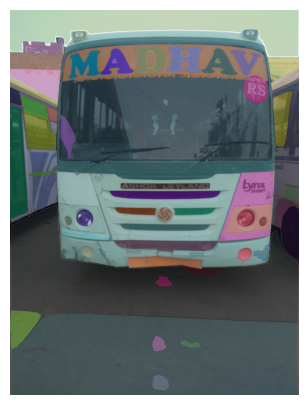

In [150]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_anns(filtered_masks)
plt.axis('off')
plt.show() 

Fine-tuned in COCO

In [ ]:
image_path = "vehicle-image-captioning-dataset/versions/1/indian_vehicle_images/indian_vehicle_images/dc_vehicle_captions_000040_nup4PwVq.jpg"
image = Image.open(image_path).convert('RGB')
image_np = np.array(image)
ground_truth = "vehicle-image-captioning-dataset/versions/1/indian_vehicle_txt_annos/indian_vehicle_txt_annos/dc_vehicle_captions_000040_nup4PwVq.txt"

# Fine-Tuned GIT
git_processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
git_captioning_model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-coco").to(device)

inputs = git_processor(images=image, return_tensors="pt").to(device)
outputs = git_captioning_model.generate(**inputs, max_new_tokens=200)
caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Generated Caption:", caption)

# WER
wer_score = wer(ground_truth, caption)
    
# BLEU
reference = [ground_truth.split()]
candidate = caption.split()
bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    
# CIDEr
gts = {0: [ground_truth]}
res = {0: [caption]}
cider_score, _ = cider_scorer.compute_score(gts, res)
print(f"BLEU: {bleu_score:.4f}, WER: {wer_score:.4f}, CIDEr: {cider_score:.4f}")

Generated Caption: a bus in the city
BLEU: 0.0000, WER: 5.0000, CIDEr: 0.0000


In [ ]:
# File paths
image_dir = "vehicle-image-captioning-dataset/versions/1/indian_vehicle_images/indian_vehicle_images"
anno_dir = "vehicle-image-captioning-dataset/versions/1/indian_vehicle_txt_annos/indian_vehicle_txt_annos"

# Fine-Tuned GIT
git_processor = AutoProcessor.from_pretrained("microsoft/git-large-coco")
git_captioning_model = AutoModelForCausalLM.from_pretrained("microsoft/git-large-coco").to(device)

image_files = sorted(os.listdir(image_dir))
anno_files = sorted(os.listdir(anno_dir))

results = []
cider_scorer = Cider()

for img_file, anno_file in zip(image_files, anno_files):
    image_path = os.path.join(image_dir, img_file)
    image = Image.open(image_path).convert('RGB')
    
    anno_path = os.path.join(anno_dir, anno_file)
    with open(anno_path, 'r') as f:
        ground_truth = f.read().strip()
    
    inputs = git_processor(images=image, return_tensors="pt").to(device)
    outputs = git_captioning_model.generate(**inputs, max_new_tokens=50)
    generated_caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # WER
    wer_score = wer(ground_truth, generated_caption)
    
    # BLEU
    reference = [ground_truth.split()]
    candidate = generated_caption.split()
    bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
    
    # CIDEr
    gts = {0: [ground_truth]}
    res = {0: [generated_caption]}
    cider_score, _ = cider_scorer.compute_score(gts, res)
    
    results.append({
        "Image": img_file,
        "Ground Truth": ground_truth,
        "Generated Caption": generated_caption,
        "BLEU": bleu_score,
        "WER": wer_score,
        "CIDEr": cider_score
    })

results_df = pd.DataFrame(results)
output_path = "git_coco_results.csv"
results_df.to_csv(output_path, index=False, encoding="utf-8")
print(f"Results saved to {output_path}")

Results saved to git_coco_results.csv


In [159]:
avg_bleu = results_df["BLEU"].mean()
avg_wer = results_df["WER"].mean()
avg_cider = results_df["CIDEr"].mean()
print(f"Average BLEU: {avg_bleu:.4f}, Average WER: {avg_wer:.4f}, Average CIDEr: {avg_cider:.4f}")

Average BLEU: 0.0001, Average WER: 0.9495, Average CIDEr: 0.0000


Tailor the generated caption toward vehicle scene understanding. However, the model repeats the prompt.

In [ ]:
# Prepare the inputs with an enhanced prompt
prompt = (
    "The image contains vehicles and pedestrians. Focus on describing the vehicles, "
    "including their positions, types, and interactions with traffic signals or people."
)

inputs = git_processor(images=image, text=prompt, return_tensors="pt").to(device)

# Generate the caption
outputs = git_captioning_model.generate(**inputs, max_new_tokens=150)
caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Improved Vehicle Scene Caption:", caption)

Improved Vehicle Scene Caption: the image contains vehicles and pedestrians. focus on describing the vehicles, including their positions, types, and interactions with traffic signals or people.


In [ ]:
output_dir = "cropped_objects"
os.makedirs(output_dir, exist_ok=True)

object_captions = []
metadata = []
filtered_masks = [
    mask for mask in masks
    if mask["predicted_iou"] > 0.9 and mask["stability_score"] > 0.85 and 500 < mask["area"] < 100000
]

for i, mask in enumerate(filtered_masks):
    try:
        segmentation = mask["segmentation"].astype("uint8")
        x, y, w, h = mask["bbox"]
        cropped_mask = cv2.bitwise_and(image, image, mask=segmentation)
        cropped_object = cropped_mask[y:y+h, x:x+w]

        cropped_pil = Image.fromarray(cropped_object)

        image_path = os.path.join(output_dir, f"cropped_object_{i}.png")
        cropped_pil.save(image_path)

        inputs = git_processor(images=cropped_pil, return_tensors="pt").to(device)
        outputs = git_captioning_model.generate(**inputs, max_new_tokens=50)
        caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

        object_captions.append(f"Object {i}: {caption}")
        print(f"Caption for Object {i}: {caption}")

        metadata.append({
            "object_index": i,
            "file_name": f"cropped_object_{i}.png",
            "bbox": mask["bbox"],
            "area": mask["area"],
            "predicted_iou": mask.get("predicted_iou", "N/A"),
            "stability_score": mask.get("stability_score", "N/A"),
            "caption": caption
        })

    except Exception as e:
        print(f"Error processing Object {i}: {e}")

metadata_path = os.path.join(output_dir, "metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
print(f"Saved metadata to {metadata_path}")


Caption for Object 0: the bus that took us to the airport in the morning.
Caption for Object 1: white spots on the tree
Caption for Object 2: the van is silver
Caption for Object 3: part of a wall
Caption for Object 4: a stone in the wall
Caption for Object 5: a wall on the side of a building
Caption for Object 6: a car ' s wheel is seen in this undated image.
Caption for Object 7: a tree in the forest
Caption for Object 8: the car ' s wheel was found in the garage.
Caption for Object 9: a picture of a person
Caption for Object 10: the grass is green
Caption for Object 11: a truck in the street
Caption for Object 12: the bus is blue in color
Caption for Object 13: black mark is spotted
Caption for Object 14: part of a surface
Caption for Object 15: the truck is white in color
Caption for Object 16: a bird in a tree
Caption for Object 17: part of a wall
Caption for Object 18: a white cloud in the sky
Caption for Object 19: a dead cow in the forest
Caption for Object 20: red light on the

In [ ]:
object_descriptions = " ".join(object_captions)
prompt = f"Here are the objects in the image: {object_descriptions}. Based on this, describe the image as a whole."

inputs = git_processor(images=image, text=prompt, return_tensors="pt").to(device)

outputs = git_captioning_model.generate(**inputs, max_new_tokens=50)
final_caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Final Comprehensive Caption:", final_caption)

Final Comprehensive Caption: here are the objects in the image : object 0 : the bus that took us to the airport in the morning. object 1 : white spots on the tree object 2 : the van is silver object 3 : part of a wall object 4 : a stone in the wall object 5 : a wall on the side of a building object 6 : a car ' s wheel is seen in this undated image. object 7 : a tree in the forest object 8 : the car ' s wheel was found in the garage. object 9 : a picture of a person object 10 : the grass is green object 11 : a truck in the street object 12 : the bus is blue in color object 13 : black mark is spotted object 14 : part of a surface object 15 : the truck is white in color object 16 : a bird in a tree object 17 : part of a wall object 18 : a white cloud in the sky object 19 : a dead cow in the forest object 20 : red light on the pole object 21 : part of a window object 22 : the candle is red object 23 : license plate on the motorcycle object 24 : the wall is brown in color object 25 : black 

In [ ]:
object_descriptions = " ".join(object_captions)
prompt = (
    f"Here are some objects detected in the image: {object_descriptions}. "
    f"Please summarize and describe the overall scene depicted in the image."
)

inputs = git_processor(images=image, text=prompt, return_tensors="pt").to(device)
outputs = git_captioning_model.generate(**inputs, max_new_tokens=100)
final_caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Improved Comprehensive Caption:", final_caption)

Improved Comprehensive Caption: here are some objects detected in the image : object 0 : the bus that took us to the airport in the morning. object 1 : white spots on the tree object 2 : the van is silver object 3 : part of a wall object 4 : a stone in the wall object 5 : a wall on the side of a building object 6 : a car ' s wheel is seen in this undated image. object 7 : a tree in the forest object 8 : the car ' s wheel was found in the garage. object 9 : a picture of a person object 10 : the grass is green object 11 : a truck in the street object 12 : the bus is blue in color object 13 : black mark is spotted object 14 : part of a surface object 15 : the truck is white in color object 16 : a bird in a tree object 17 : part of a wall object 18 : a white cloud in the sky object 19 : a dead cow in the forest object 20 : red light on the pole object 21 : part of a window object 22 : the candle is red object 23 : license plate on the motorcycle object 24 : the wall is brown in color objec

Remove Prefixes

In [108]:
# Clean up captions by removing "Object X:" prefixes
cleaned_captions = [caption.split(": ", 1)[1] for caption in object_captions if ": " in caption]

# Combine captions for the summarization prompt
object_descriptions = " ".join(cleaned_captions)

# Construct the improved prompt
prompt = (
    f"The image contains the following objects: {object_descriptions}. "
    f"Please summarize the overall content of the image."
)

# Generate comprehensive caption
inputs = git_processor(images=image, text=prompt, return_tensors="pt").to(device)
outputs = git_captioning_model.generate(**inputs, max_new_tokens=100)
final_caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Final Comprehensive Caption (Without Prefixes):", final_caption)

Final Comprehensive Caption (Without Prefixes): the image contains the following objects : the bus that took us to the airport in the morning. white spots on the tree the van is silver part of a wall a stone in the wall a wall on the side of a building a car ' s wheel is seen in this undated image. a tree in the forest the car ' s wheel was found in the garage. a picture of a person the grass is green a truck in the street the bus is blue in color black mark is spotted part of a surface the truck is white in color a bird in a tree part of a wall a white cloud in the sky a dead cow in the forest red light on the pole part of a window the candle is red license plate on the motorcycle the wall is brown in color black fabric on shirt orange stripe on the truck the wall in the background is brown. a tall tower in the sky a building in the background the dog is black. please summarize the overall content of the image.


In [ ]:
prompt = (
    f"The following captions describe objects in an image: {object_descriptions} "
    f"Summarize these captions into a cohesive description of the entire scene."
)

inputs = git_processor(text=prompt, return_tensors="pt").to(device)
outputs = git_captioning_model.generate(**inputs, max_new_tokens=100)
final_caption = git_processor.tokenizer.decode(outputs[0], skip_special_tokens=True)

print("Summarized Scene Description:", final_caption)

Summarized Scene Description: the following captions describe objects in an image : the bus that took us to the airport in the morning. white spots on the tree the van is silver part of a wall a stone in the wall a wall on the side of a building a car ' s wheel is seen in this undated image. a tree in the forest the car ' s wheel was found in the garage. a picture of a person the grass is green a truck in the street the bus is blue in color black mark is spotted part of a surface the truck is white in color a bird in a tree part of a wall a white cloud in the sky a dead cow in the forest red light on the pole part of a window the candle is red license plate on the motorcycle the wall is brown in color black fabric on shirt orange stripe on the truck the wall in the background is brown. a tall tower in the sky a building in the background the dog is black summarize these captions into a cohesive description of the entire scene.
